In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import json

# Define functions

In [9]:
# Create and display pie chart with value + percent labels
def autopct_format(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return autopct


def do_pie_chart(data: pd.DataFrame, title: str=f'Overall readmission status distribution', column_to_count_on:str = "readmitted_binary", counted_values:list = [0, 1], ax: plt.axes = None, fig_path: str = None):

    if ax is None:
        fig, ax = plt.subplots(figsize = (5, 5))
        plt.title(title)
    else:
        ax.set_title(title)

    # Count occurrences
    counts = data.copy()[column_to_count_on].value_counts().reindex(counted_values, fill_value=0)

    counts.index = ["readmitted" if i == 1 else "not readmitted" for i in counts.index]

    counts.plot.pie(
        labels=counts.index,
        autopct=autopct_format(counts),
        ylabel='',
        startangle=90,
        counterclock=False,
        shadow=False,
        ax=ax
    )

    plt.tight_layout()

    if fig_path is not None:
        fig.savefig(fig_path)

    return plt.gcf(), plt.gca()

# Data reading and addition of new diabetes features

In [10]:
data = pd.read_csv("../data/processed/diabetes_cleaned_data.csv")
print(data.columns)
print(data.head())

Index(['patient_nbr', 'encounter_id', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'diag_1_category', 'diag_2_category',
       'diag_3_category', 'diab_code', 'diab_type', 'diab_control',
       'diab_complication_

In [11]:
import pandas as pd

# --- define the medication groups ---

increase_sensitivity = [
    "metformin", "pioglitazone", "rosiglitazone", "troglitazone",
    "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"
]

increase_production = [
    "chlorpropamide", "glimepiride", "glipizide", "glyburide", "tolbutamide",
    "acetohexamide", "tolazamide", "repaglinide", "nateglinide",
    "examide", "insulin", "citoglipton",
    "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone"
]

slow_assimilation = ["acarbose", "miglitol"]

# --- Helper function to summarize the group change per patient ---
def summarize_drug_group(row, drugs):
    values = row[drugs]
    # Keep only non-"No" values
    active = values[values != "No"].unique()
    if len(active) == 0:
        return "No"
    if len(active) == 1:
        return active[0]  # Only one type of change
    return "Multiple changes"  # Different types (e.g., Up and Down, or Up and Steady)

# --- Apply to each patient (row) ---
data["insulin_sensitivity_change"] = data.apply(lambda row: summarize_drug_group(row, increase_sensitivity), axis=1)
data["insulin_production_change"] = data.apply(lambda row: summarize_drug_group(row, increase_production), axis=1)
data["sugar_assimilation_change"] = data.apply(lambda row: summarize_drug_group(row, slow_assimilation), axis=1)


# New diabetes related features relation with target feature

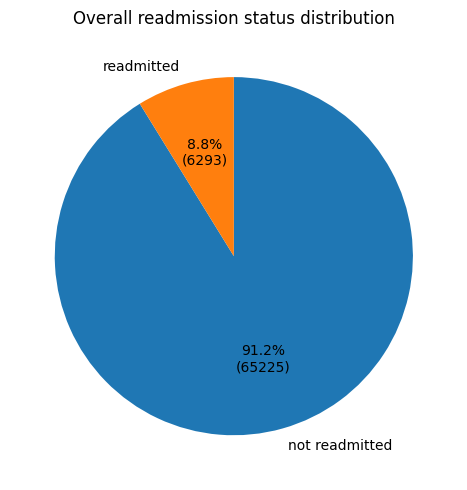

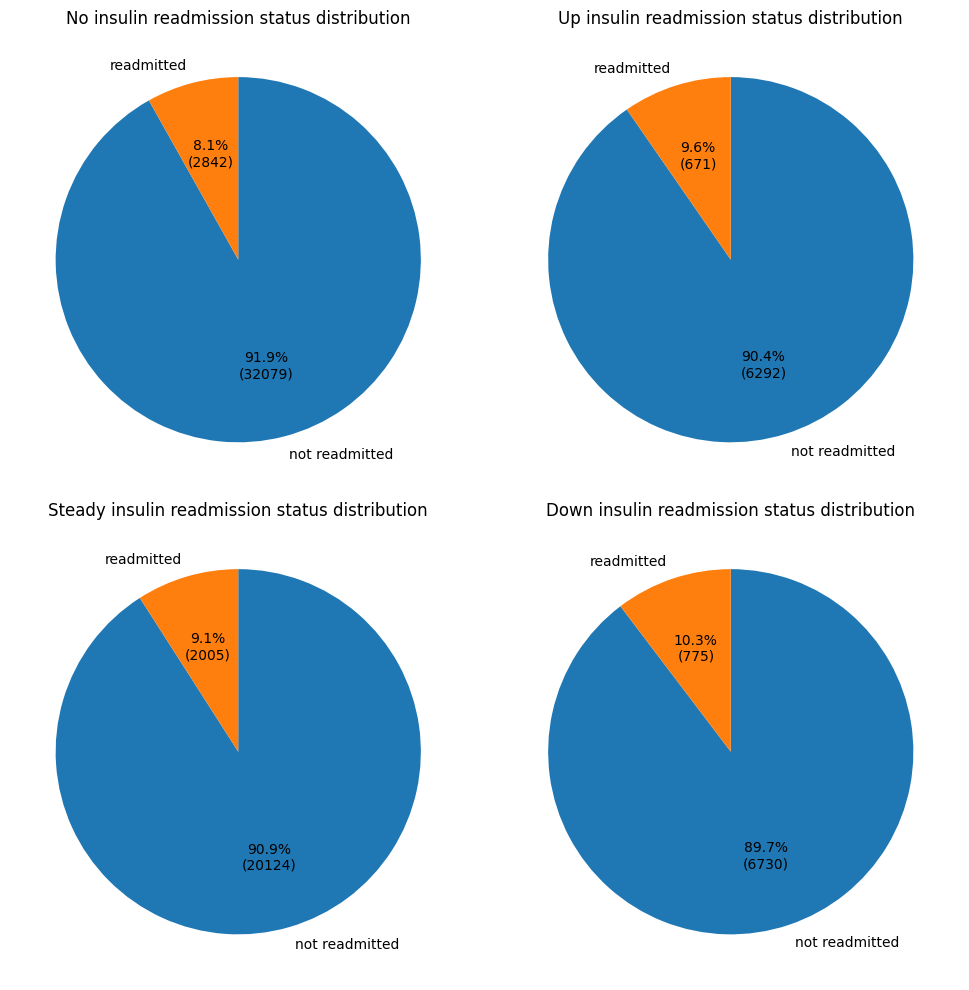

In [12]:
# Overall readmission status distribution
fig, ax = do_pie_chart(data=data, fig_path="figures/medications_changes_impact/overall.png")

# per diabetes type readmisison status distribution
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for ax, insulin in zip(axs, list(set(data.insulin.values))):
    do_pie_chart(data=data.copy()[data.insulin == insulin], title=f"{insulin} insulin readmission status distribution", ax=ax)
plt.savefig("figures/medications_changes_impact/insulin_changes.png")

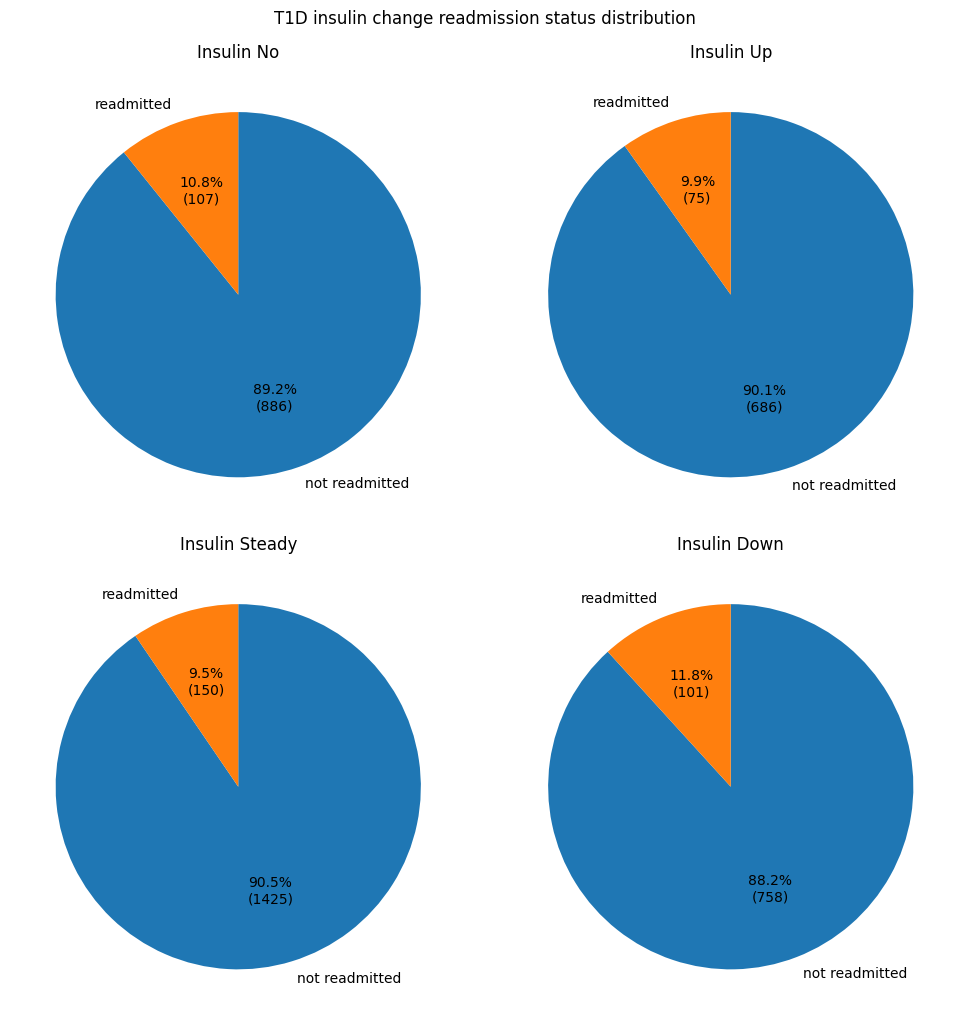

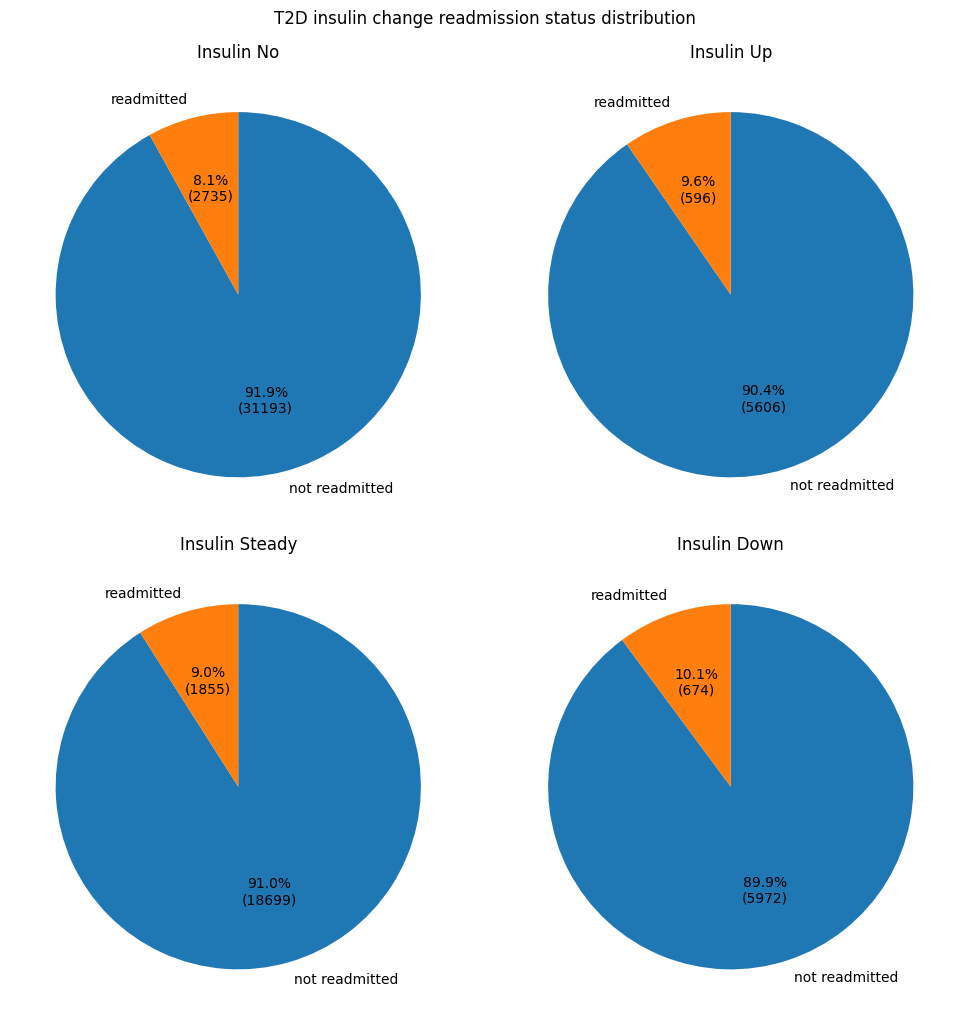

In [13]:
# per complication status distribution
insulin_changes_categories = list(set(data.insulin.values))
for diab_type in [1, 2]:
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    # per diabetes type readmisison status distribution
    for ax, insulin in zip(axs, insulin_changes_categories):
        selected_data = data.copy()[(data.insulin == insulin) & (data.diab_type == diab_type)]
        if len(selected_data.index) > 0:
            do_pie_chart(data=selected_data, title=f"Insulin {insulin}", ax=ax)
    plt.gcf().suptitle(f"T{diab_type}D insulin change readmission status distribution", y=1.02)
    plt.gcf().savefig(f"figures/medications_changes_impact/t{diab_type}d_insulin_changes.png")

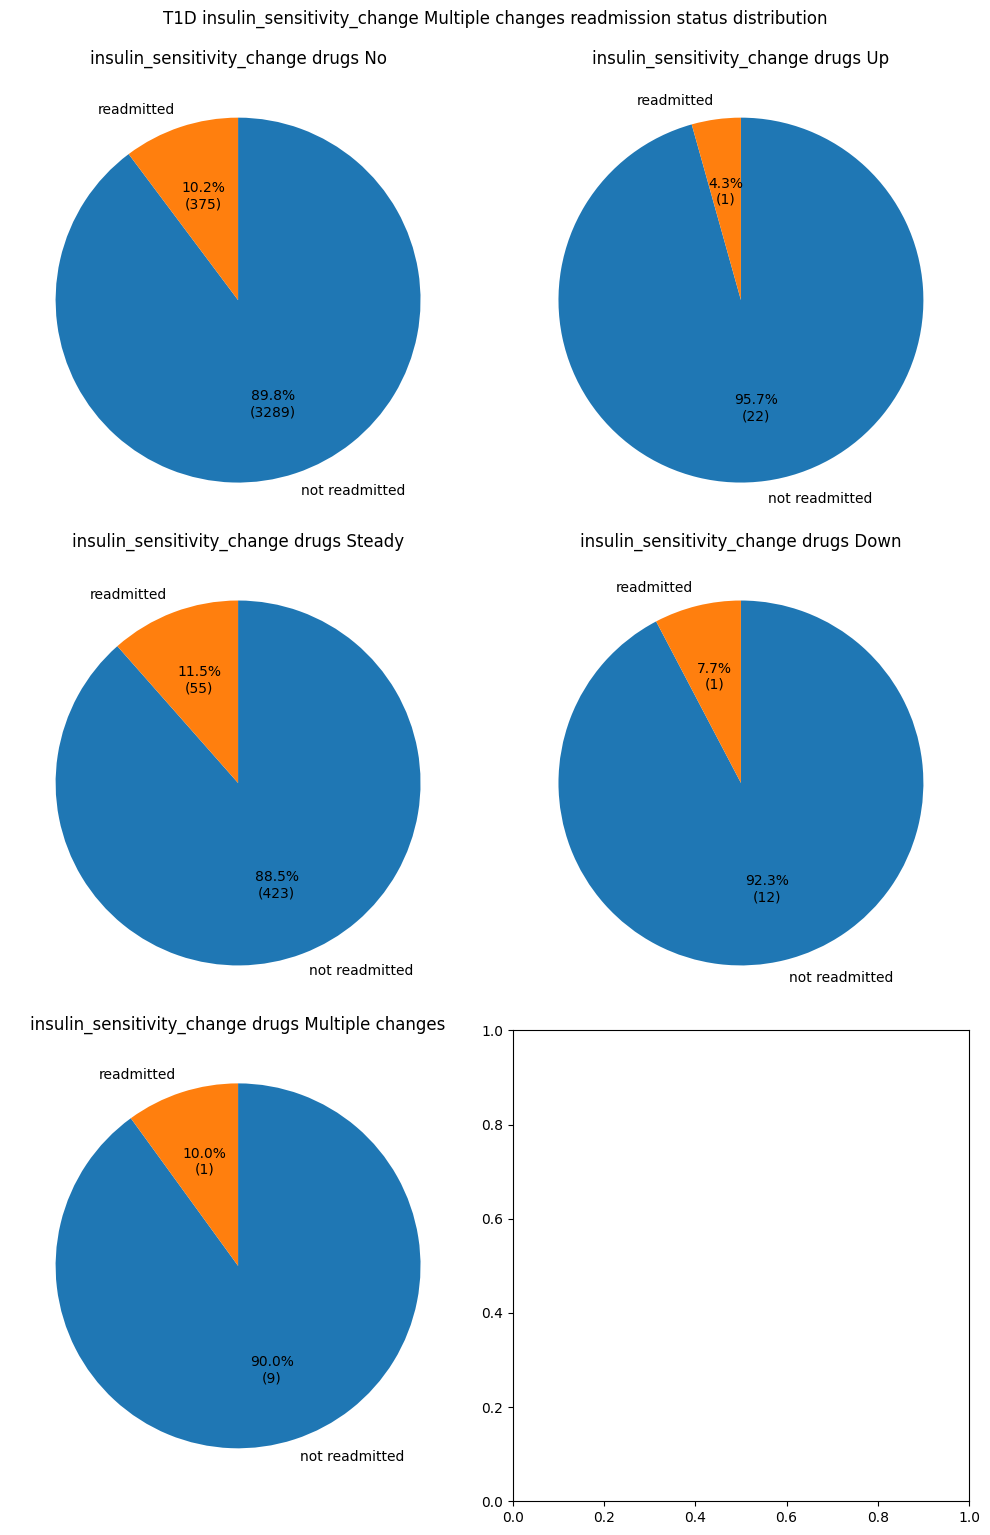

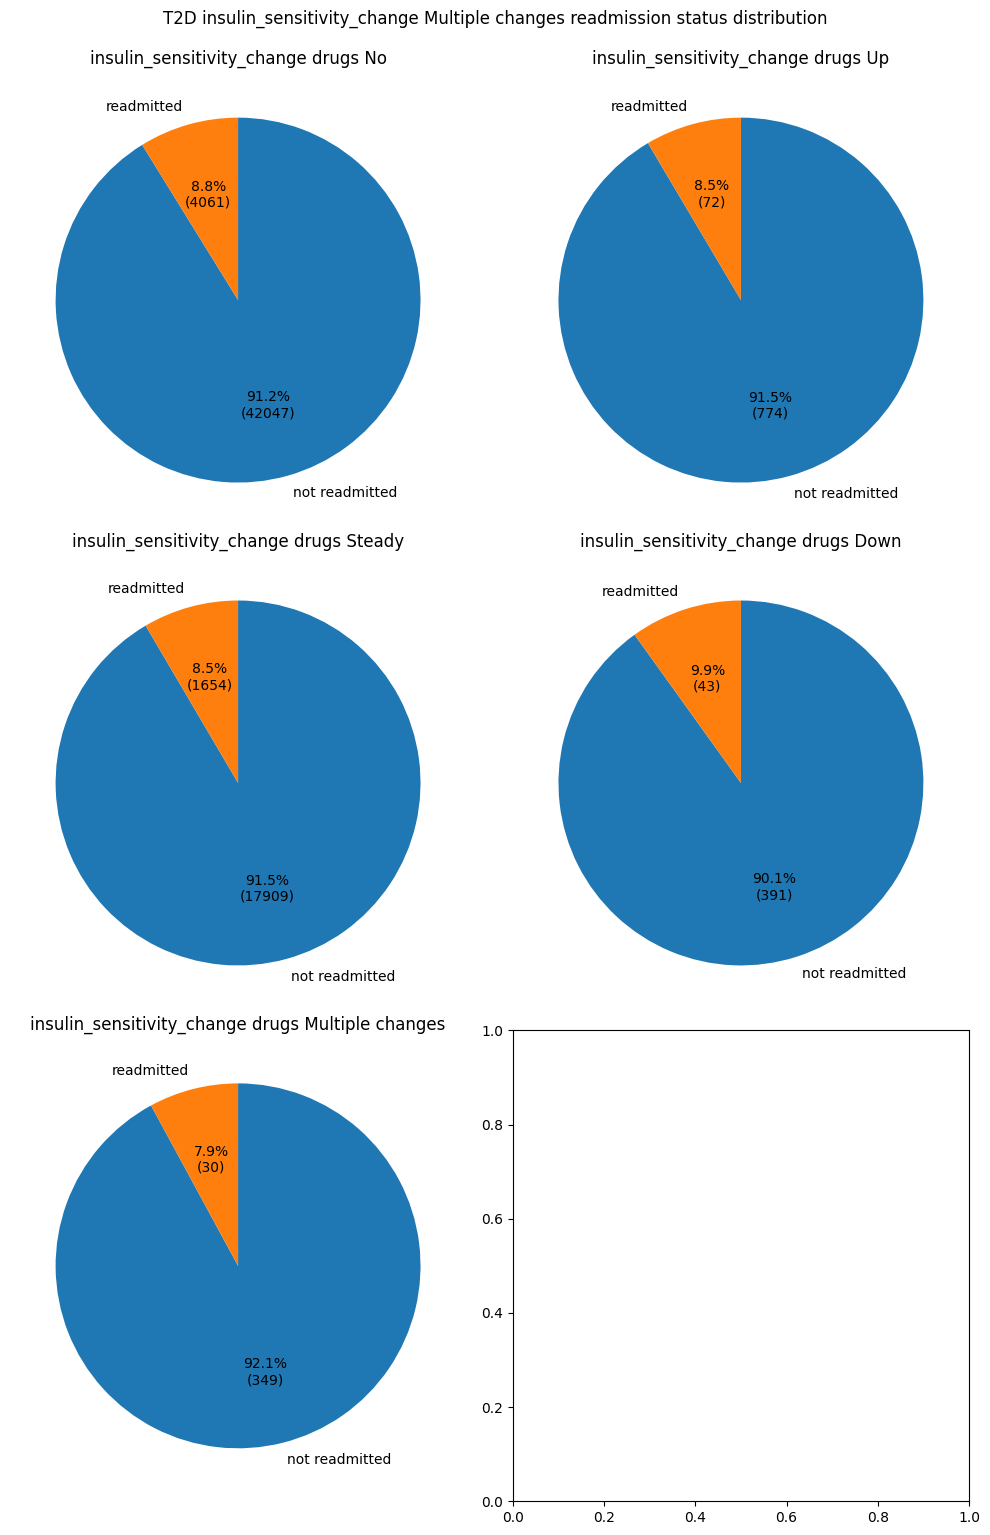

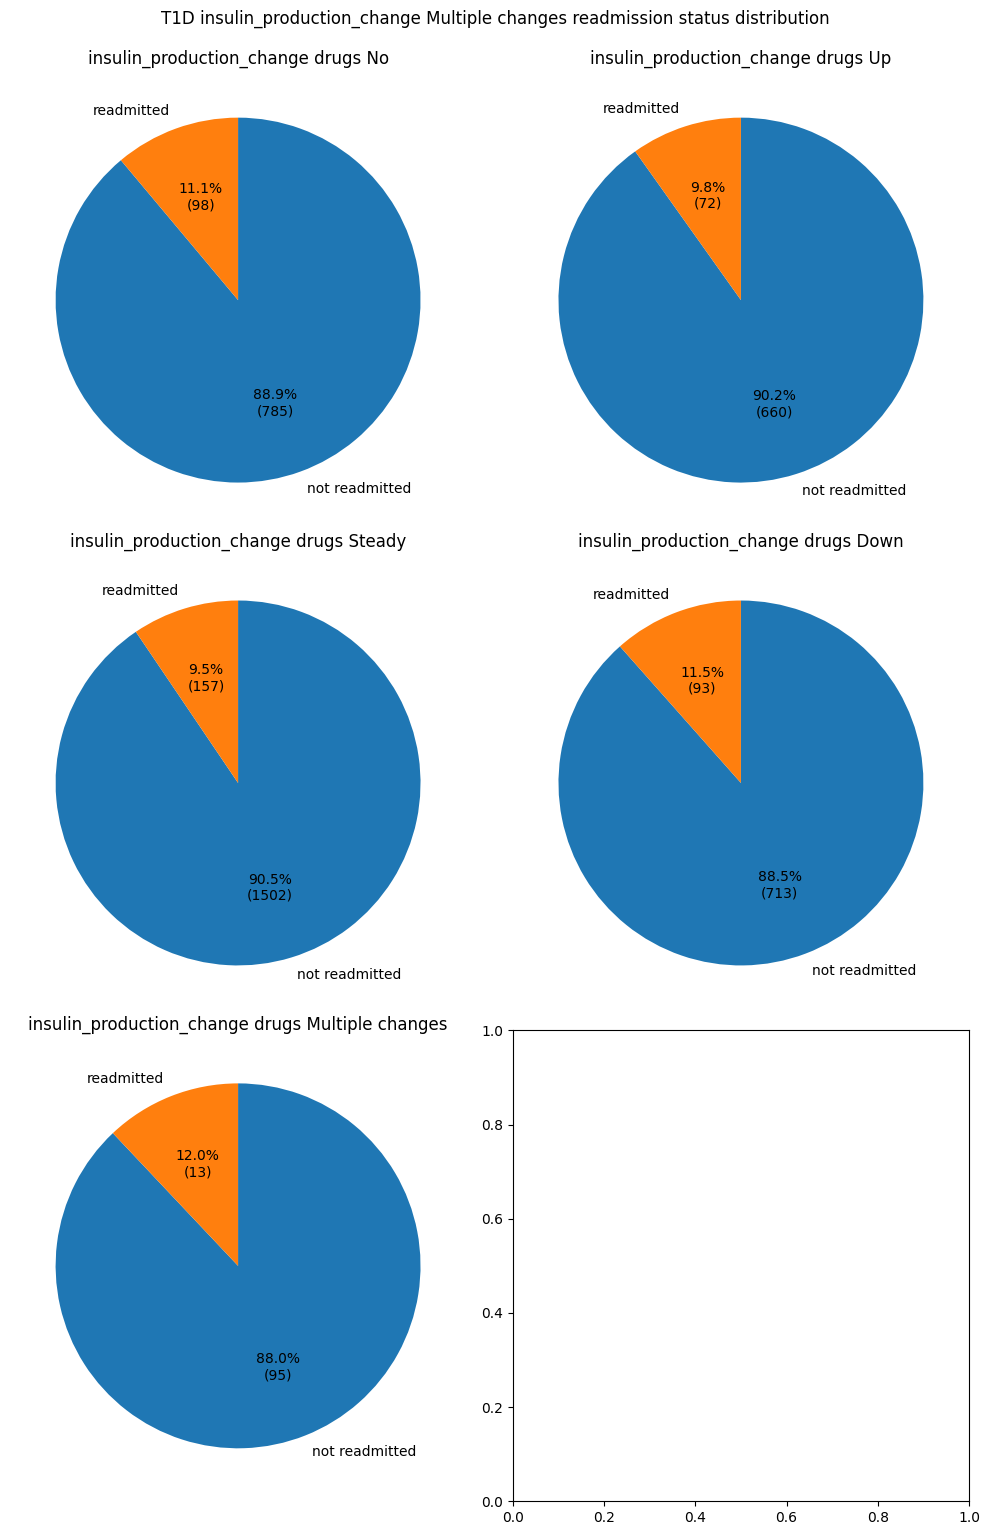

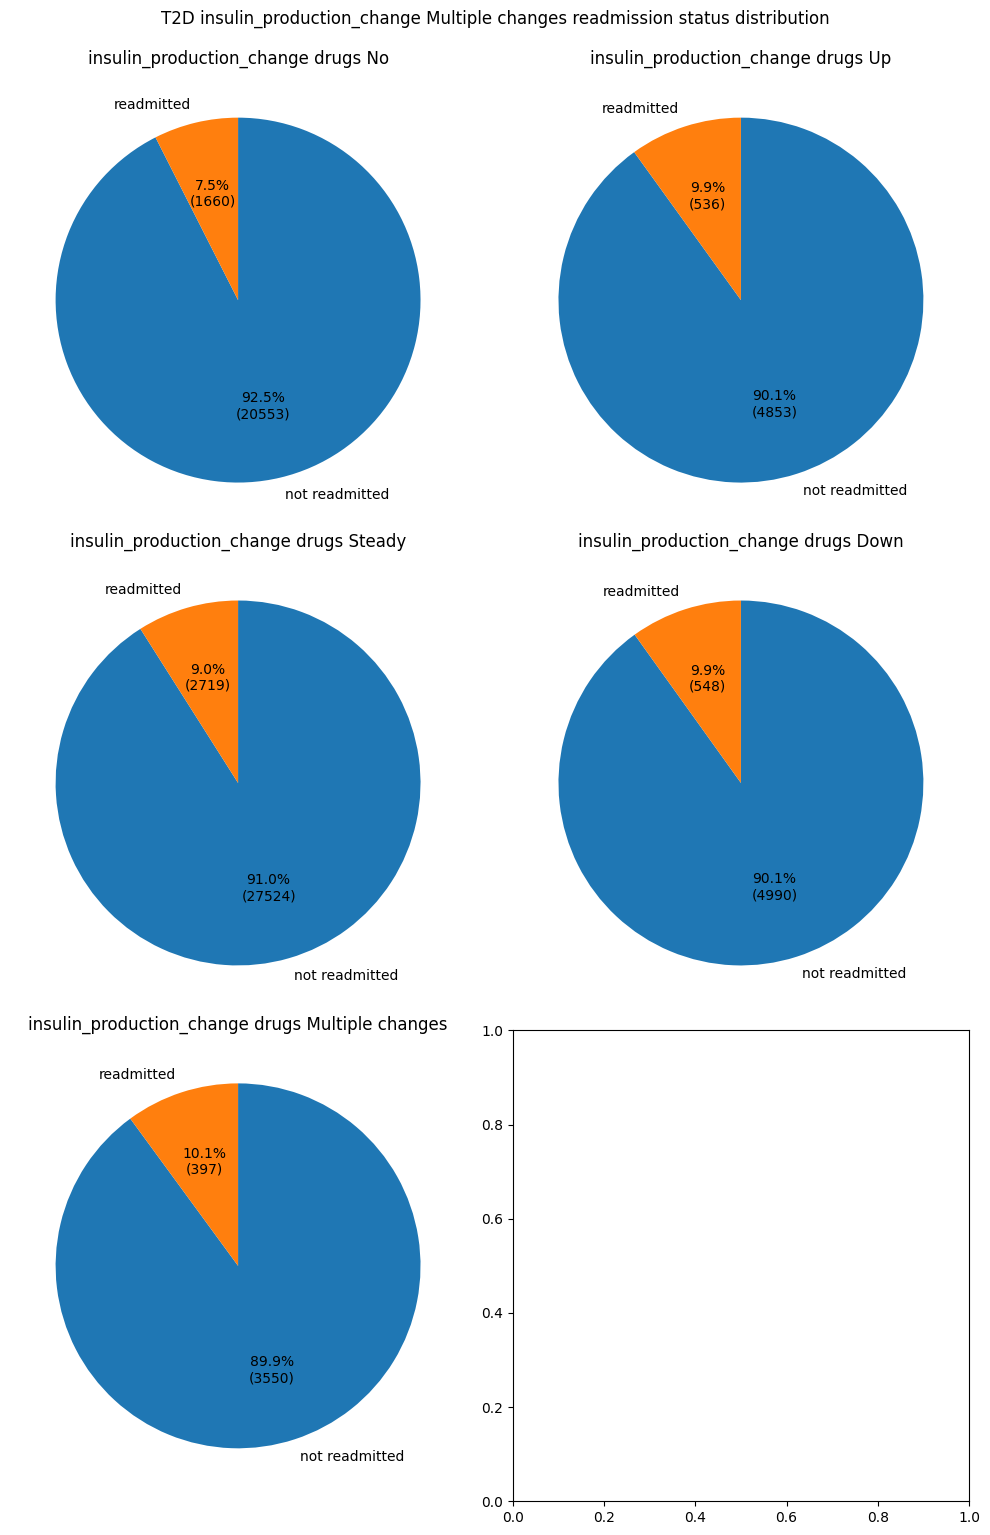

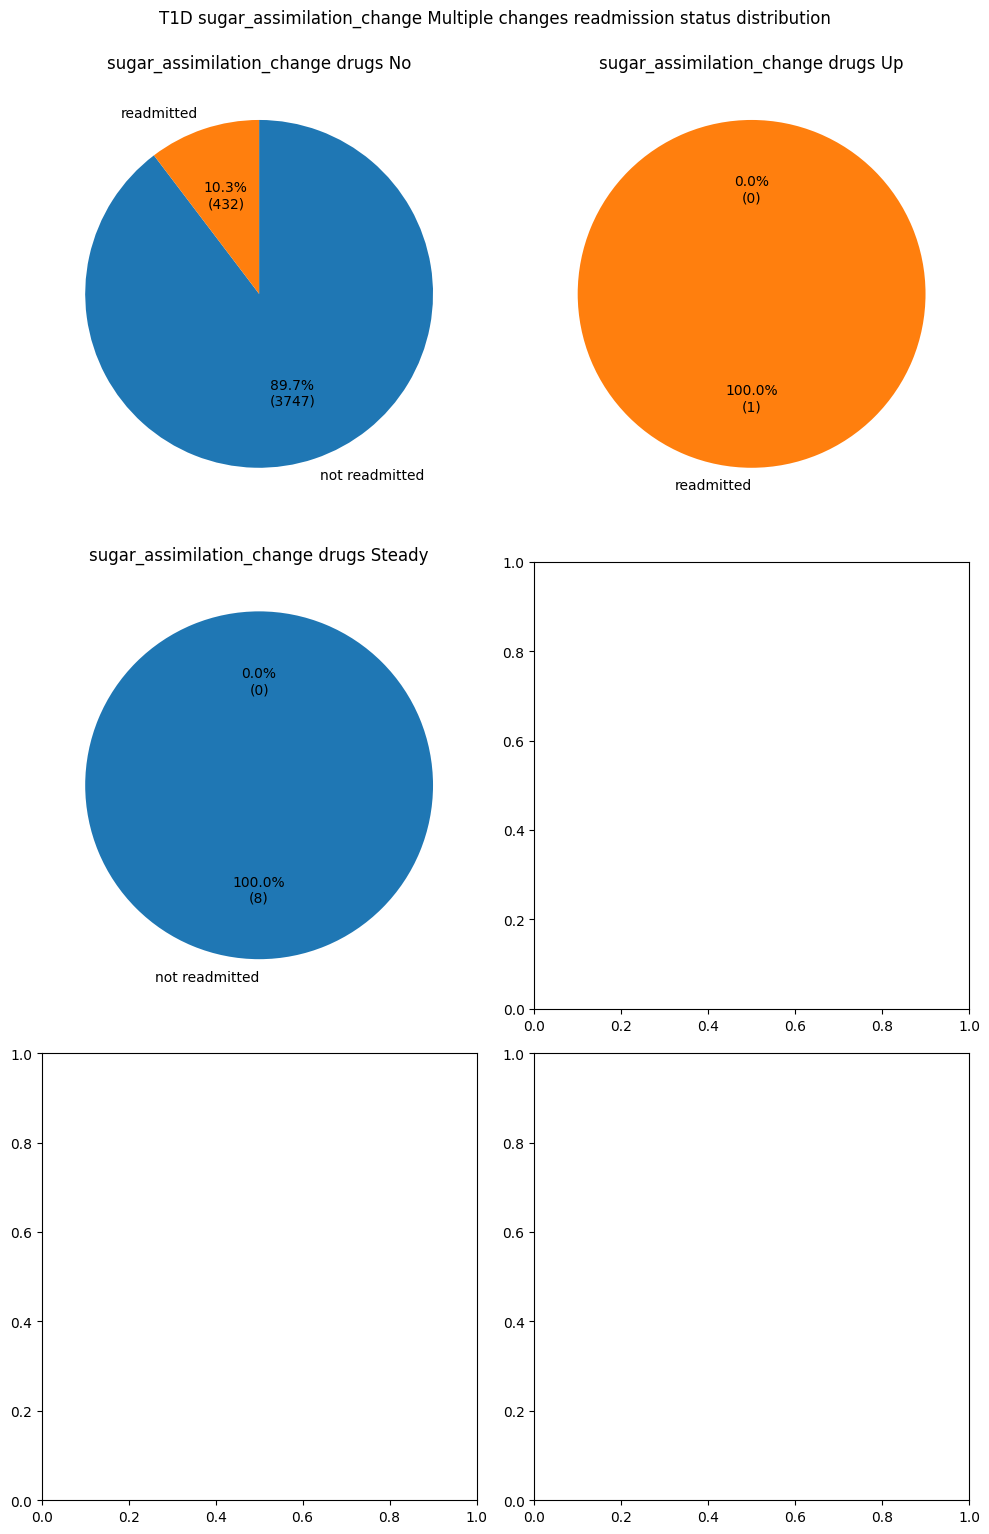

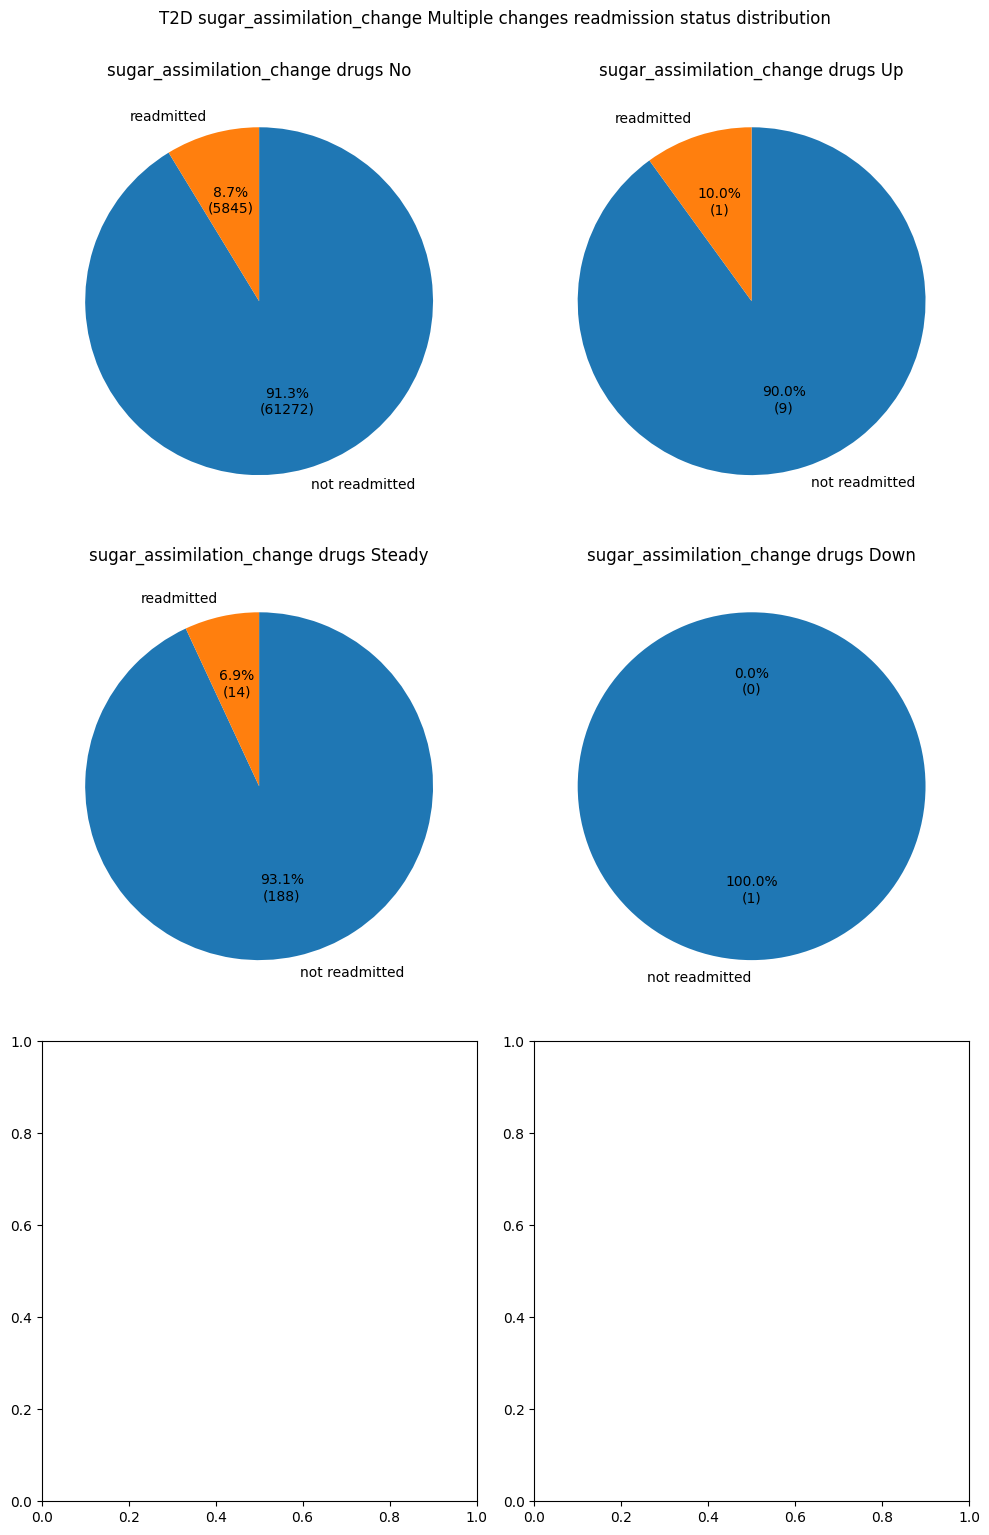

In [14]:
insulin_changes_categories = list(set(data.insulin.values)) + ["Multiple changes"]

for med_type in ["insulin_sensitivity_change", "insulin_production_change", "sugar_assimilation_change"]:
    for diab_type in [1, 2]:
        fig, axs = plt.subplots(3, 2, figsize=(10, 15))
        axs = axs.flatten()
        # per diabetes type readmisison status distribution
        for ax, insulin in zip(axs, insulin_changes_categories):
            selected_data = data.copy()[(data[med_type] == insulin) & (data.diab_type == diab_type)]
            if len(selected_data.index) > 0:
                do_pie_chart(data=selected_data, title=f"{med_type} drugs {insulin}", ax=ax)
        plt.gcf().suptitle(f"T{diab_type}D {med_type} {insulin} readmission status distribution", y=1.02)
        plt.gcf().savefig(f"figures/medications_changes_impact/t{diab_type}d_{med_type}_changes.png")